# Clasificación de iconos con MLP (MultiLayer Perceptron Classifier)

In [70]:
%matplotlib inline

#Importamos las librerías a usar
import torch                                #Tensores
import torch.nn as nn                       #Redes
import torch.nn.functional as F             #Funciones de activación
from torchvision import datasets, transforms#Dataset

import numpy as np                          #Vectores/Arrays
import matplotlib.pyplot as plt             #Gráficas

#Averiguamos si es posible usar cuda
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
#Mostramos el resultado
print('Using PyTorch version:', torch.__version__, ' Device:', device)

Using PyTorch version: 1.12.1+cu102  Device: cuda


## Creación de los cargadores de datos.

In [71]:
#tamaño del batch o lotes
batch_size = 30

#Realizamos la trasformaciones a tensor y a un escalado
transforms = transforms.Compose([transforms.ToTensor(),
                                 transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
                                ])

#Descargamos el dataset de entrenamiento con CIFAR10
train_dataset = datasets.CIFAR10('/tmp/data', 
                               train=True, 
                               download=True, 
                               transform=transforms)

#Descargamos el dataset de validación con CIFAR10
validation_dataset = datasets.CIFAR10('/tmp/data', 
                                    train=False, 
                                    transform=transforms)

#Realizamos los cargadores de entrenamiento y validación con el tamaño de batch establecido anteriormente
#Cargador de entrenamiento
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)
#cargador de validación
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, 
                                                batch_size=batch_size, 
                                                shuffle=False)

Files already downloaded and verified


The train and test data are provided via data loaders that provide iterators over the datasets. The first element of training data (`X_train`) is a 4th-order tensor of size (`batch_size`, 3, 32, 32), i.e. it consists of a batch of images of size 3x32x32 pixels. `y_train` is a vector containing the correct classes ("0", "1", ..., "9") for each training icon.

In [72]:
#Mostramos los tamaños de los lotes, viéndose 30 del lote, 3 de la capa rgb, 32 y 32 del tamaño de la imagen 
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([30, 3, 32, 32]) type: torch.FloatTensor
y_train: torch.Size([30]) type: torch.LongTensor


Mostramos los 10 primeros dígitos:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

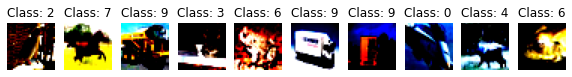

In [73]:
pltsize=1
#creamos un "marco" para mostrar 10 figuras
plt.figure(figsize=(10*pltsize, pltsize))

#Recorremos 10 figuras del ultimo lote obtenido en el anterior código
for i in range(10):
    #Creamos division de 1 a 10 figuras y las posicionamos en su orden 
    plt.subplot(1,10,i+1)
    plt.axis('off')
    #Mostramos la i-esima imagen, habrá que hacerle transpose ya que el estándar es tamaño [x, y, colores], y no [colores, y, x], como vimos anteriormente
    plt.imshow(np.transpose(X_train[i,:,:,:].numpy(), (1,2,0)))
    #Ponemos como titulo la etiqueta
    plt.title('Class: '+str(y_train[i].item()))

## Definición del modelo MLP.

Este modelo tiene 3 capas, 2 de ellas con 50 neuronas y 1 con 10.
Función de activación ReLU después de las 2 primeras capas y softmax a la útlima.



In [74]:
#Definimos la red 
class Net(nn.Module):
    #Definición de la topografía de la red
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(3*32*32, 50) #Primera capa. Entrada de la imagen rgb de 32*32 a una salida de 50
        self.fc2 = nn.Linear(50, 50)      #Segunda capa. Entrada de 50 a 50   
        self.fc3 = nn.Linear(50, 10)      #Ultima capa. Entrada de 50 a 10 siendo esta la las 10 etiquetas posibles a clasificar

    #Definición de funciones de activación
    def forward(self, x):
        x = x.view(-1, 3*32*32) #convertimos la imagen rgb de 32*32 en un vector de una dimensión
        x = F.relu(self.fc1(x)) #Relu en la primera capa
        x = F.relu(self.fc2(x)) #Relu en la segunda capa
        return self.fc3(x)      #¿Terminamos con la ultima capa sin función de activación?


## Creación del modelo, optimizador y función de pérdida.


In [75]:
#Instanciamos la red con el dispositivo establecido en el primer código, cuda o cpu
model = Net().to(device)
#Creamos el optimizador tipo SGD
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
#Usamos crossEntropy para la función de perdida
criterion = nn.CrossEntropyLoss()

#Imprimimos el resultado de como a quedado la red
print(model)

Net(
  (fc1): Linear(in_features=3072, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=10, bias=True)
)


## Learning

Definición del método de entrenamiento `train()` y del método de validación `validate()`. 

In [76]:
#Función de entrenamiento
def train(epoch, log_interval=200):
    # Set model to training mode
    model.train()
    
    # Loop over each batch from the training set
    for batch_idx, (data, target) in enumerate(train_loader):
        # Copy data to GPU if needed
        data = data.to(device)
        target = target.to(device)

        # Zero gradient buffers
        optimizer.zero_grad() 
        
        # Pass data through the network
        output = model(data)

        # Calculate loss
        loss = criterion(output, target)

        # Backpropagate
        loss.backward()
        
        # Update weights
        optimizer.step()
        
        #Cada intervalo ponemos un mensaje de progreso
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))

In [77]:
#Función de activación
def validate(loss_vector, accuracy_vector):
    #Ponemos el modelo en modo validación
    model.eval()
    val_loss, correct = 0, 0

    #Recorremos el cargador de validación
    for data, target in validation_loader:
        #Copiamos en GPU si fuera posible
        data = data.to(device)
        target = target.to(device)
        #Obtenemos perdición del lote
        output = model(data)
        #Calculamos el loss y acumulamos, .data.item() para sacar el valor del tensor
        val_loss += criterion(output, target).data.item()
        #Obtenemos perdición con mayor probabilidad
        pred = output.data.max(1)[1] # get the index of the max
        #Acumulamos la suma de correctos para el accuracy, hay que extraerlo de la gpu con .cpu()
        correct += pred.eq(target.data).cpu().sum()

    #Hacemos media del loss y acuraccy para introducirlo a una lista, para ver el progreso
    val_loss /= len(validation_loader)
    loss_vector.append(val_loss)

    accuracy = 100. * correct.to(torch.float32) / len(validation_loader.dataset)
    accuracy_vector.append(accuracy)
    
    #Mostramos los valores actuales
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(validation_loader.dataset), accuracy))


# Bucle de entrenamiento

Por cada epoch, vamos a entrenar y después a validar el modelo

In [78]:
%%time
#se realizara 10 épocas
epochs = 10

lossv, accv = [], []
#Realizamos la 10 épocas de entrenamiento y después validación
for epoch in range(1, epochs + 1):
    train(epoch)
    validate(lossv, accv)

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.310501
Train Epoch: 1 [6000/50000 (12%)]	Loss: 1.715828
Train Epoch: 1 [12000/50000 (24%)]	Loss: 2.033274
Train Epoch: 1 [18000/50000 (36%)]	Loss: 1.680567
Train Epoch: 1 [24000/50000 (48%)]	Loss: 1.856601
Train Epoch: 1 [30000/50000 (60%)]	Loss: 1.885617
Train Epoch: 1 [36000/50000 (72%)]	Loss: 1.552222
Train Epoch: 1 [42000/50000 (84%)]	Loss: 1.525629
Train Epoch: 1 [48000/50000 (96%)]	Loss: 1.370444

Validation set: Average loss: 1.5734, Accuracy: 4460/10000 (45%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.606140
Train Epoch: 2 [6000/50000 (12%)]	Loss: 1.588290
Train Epoch: 2 [12000/50000 (24%)]	Loss: 1.561965
Train Epoch: 2 [18000/50000 (36%)]	Loss: 1.239705
Train Epoch: 2 [24000/50000 (48%)]	Loss: 1.422613
Train Epoch: 2 [30000/50000 (60%)]	Loss: 1.382153
Train Epoch: 2 [36000/50000 (72%)]	Loss: 1.647483
Train Epoch: 2 [42000/50000 (84%)]	Loss: 1.587869
Train Epoch: 2 [48000/50000 (96%)]	Loss: 1.469509

Validation set: Average loss: 1.4976, Accura

Visualización del proceso de entrenamiento

* *Loss* diferencia entre la salida del modelo y la real.  Hay que minimizarla hasta 0, para ello usamos el optimizador.
* *Accuracy* es la precisión del modelo.

Text(0.5, 1.0, 'validation accuracy')

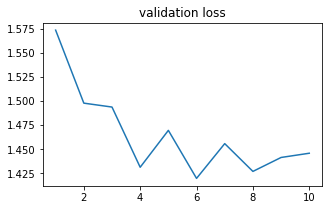

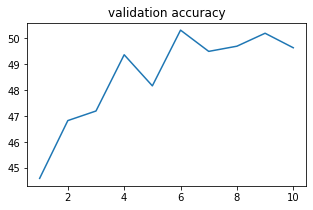

In [79]:
#Mostramos los resultados en gráficas
#loss de validación
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), lossv)
plt.title('validation loss')

#accuracy de validación
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), accv)
plt.title('validation accuracy')